In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data = pd.read_csv('C://Users//timbe//Downloads//IN_youtube_trending_data.csv')

In [8]:
data.shape

(174715, 16)

In [9]:
data.describe()

,categoryId,view_count,likes,dislikes,comment_count
count,174715.000000,1.747150e+05,1.747150e+05,1.747150e+05,1.747150e+05
mean,20.873760,3.045734e+06,1.604303e+05,3.355702e+03,9.516117e+03
std,6.003935,7.318244e+06,4.265408e+05,8.632561e+04,8.190127e+04
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,20.000000,4.378085e+05,1.593400e+04,0.000000e+00,3.950000e+02
50%,24.000000,1.064467e+06,4.689100e+04,1.770000e+02,1.284000e+03
75%,24.000000,2.705836e+06,1.383515e+05,1.549000e+03,4.487500e+03
max,29.000000,2.644074e+08,1.611524e+07,1.234147e+07,6.738565e+06


In [10]:
data.head(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Iot0eF6EoNA,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,2020-08-12T04:31:41Z,UCGqvJPRcv7aVFun-eTsatcA,FoxStarHindi,24,2020-08-12T00:00:00Z,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,224925,3979409,350210,https://i.ytimg.com/vi/Iot0eF6EoNA/default.jpg,False,False,Three Streams. Three Stories. One Journey. Sta...
1,x-KbnJ9fvJc,Kya Baat Aa : Karan Aujla (Official Video) Tan...,2020-08-11T09:00:11Z,UCm9SZAl03Rev9sFwloCdz1g,Rehaan Records,10,2020-08-12T00:00:00Z,[None],11308046,655450,33242,405146,https://i.ytimg.com/vi/x-KbnJ9fvJc/default.jpg,False,False,Singer/Lyrics: Karan Aujla Feat Tania Music/ D...
2,KX06ksuS6Xo,Diljit Dosanjh: CLASH (Official) Music Video |...,2020-08-11T07:30:02Z,UCZRdNleCgW-BGUJf-bbjzQg,Diljit Dosanjh,10,2020-08-12T00:00:00Z,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,296533,6179,30058,https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg,False,False,CLASH official music video performed by DILJIT...


In [11]:
data.drop(['video_id', 'channelId'], axis = 1, inplace = True)

In [12]:
data.head(3)

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,2020-08-12T04:31:41Z,FoxStarHindi,24,2020-08-12T00:00:00Z,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,224925,3979409,350210,https://i.ytimg.com/vi/Iot0eF6EoNA/default.jpg,False,False,Three Streams. Three Stories. One Journey. Sta...
1,Kya Baat Aa : Karan Aujla (Official Video) Tan...,2020-08-11T09:00:11Z,Rehaan Records,10,2020-08-12T00:00:00Z,[None],11308046,655450,33242,405146,https://i.ytimg.com/vi/x-KbnJ9fvJc/default.jpg,False,False,Singer/Lyrics: Karan Aujla Feat Tania Music/ D...
2,Diljit Dosanjh: CLASH (Official) Music Video |...,2020-08-11T07:30:02Z,Diljit Dosanjh,10,2020-08-12T00:00:00Z,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,296533,6179,30058,https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg,False,False,CLASH official music video performed by DILJIT...


In [13]:
# Checking null values
data.isna().sum()

title                    0
publishedAt              0
channelTitle             1
categoryId               0
trending_date            0
tags                     0
view_count               0
likes                    0
dislikes                 0
comment_count            0
thumbnail_link           0
comments_disabled        0
ratings_disabled         0
description          17154
dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174715 entries, 0 to 174714
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   title              174715 non-null  object
 1   publishedAt        174715 non-null  object
 2   channelTitle       174714 non-null  object
 3   categoryId         174715 non-null  int64 
 4   trending_date      174715 non-null  object
 5   tags               174715 non-null  object
 6   view_count         174715 non-null  int64 
 7   likes              174715 non-null  int64 
 8   dislikes           174715 non-null  int64 
 9   comment_count      174715 non-null  int64 
 10  thumbnail_link     174715 non-null  object
 11  comments_disabled  174715 non-null  bool  
 12  ratings_disabled   174715 non-null  bool  
 13  description        157561 non-null  object
dtypes: bool(2), int64(5), object(7)
memory usage: 16.3+ MB


In [15]:
# Converting 'publishedAt' and 'trending_date' to datetime objects

data['publishedAt'] = pd.to_datetime(data['publishedAt'])
data['trending_date'] = pd.to_datetime(data['trending_date'])

In [16]:
# Validating the above changes

data.dtypes[['publishedAt', 'trending_date']]

publishedAt      datetime64[ns, UTC]
trending_date    datetime64[ns, UTC]
dtype: object

In [17]:
# Getting new column 'daysTakenToTrend' which gives us the information about the number of days taken by the video to get into the trending videos

data['daysTakenToTrend'] = (data['trending_date'] - data['publishedAt']).dt.days

# Validating the above code

data.head()

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,daysTakenToTrend
0,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,2020-08-12 04:31:41+00:00,FoxStarHindi,24,2020-08-12 00:00:00+00:00,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,224925,3979409,350210,https://i.ytimg.com/vi/Iot0eF6EoNA/default.jpg,False,False,Three Streams. Three Stories. One Journey. Sta...,-1
1,Kya Baat Aa : Karan Aujla (Official Video) Tan...,2020-08-11 09:00:11+00:00,Rehaan Records,10,2020-08-12 00:00:00+00:00,[None],11308046,655450,33242,405146,https://i.ytimg.com/vi/x-KbnJ9fvJc/default.jpg,False,False,Singer/Lyrics: Karan Aujla Feat Tania Music/ D...,0
2,Diljit Dosanjh: CLASH (Official) Music Video |...,2020-08-11 07:30:02+00:00,Diljit Dosanjh,10,2020-08-12 00:00:00+00:00,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,296533,6179,30058,https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg,False,False,CLASH official music video performed by DILJIT...,0
3,Dil Ko Maine Di Kasam Video | Amaal M Ft.Ariji...,2020-08-10 05:30:49+00:00,T-Series,10,2020-08-12 00:00:00+00:00,hindi songs|2020 hindi songs|2020 new songs|t-...,23564512,743931,84162,136942,https://i.ytimg.com/vi/UsMRgnTcchY/default.jpg,False,False,Gulshan Kumar and T-Series presents Bhushan Ku...,1
4,"Baarish (Official Video) Payal Dev,Stebin Ben ...",2020-08-11 05:30:13+00:00,VYRLOriginals,10,2020-08-12 00:00:00+00:00,VYRL Original|Mohsin Khan|Shivangi Joshi|Payal...,6783649,268817,8798,22984,https://i.ytimg.com/vi/WNSEXJJhKTU/default.jpg,False,False,VYRL Originals brings to you ‘Baarish’ - the b...,0


<AxesSubplot:xlabel='daysTakenToTrend', ylabel='Count'>

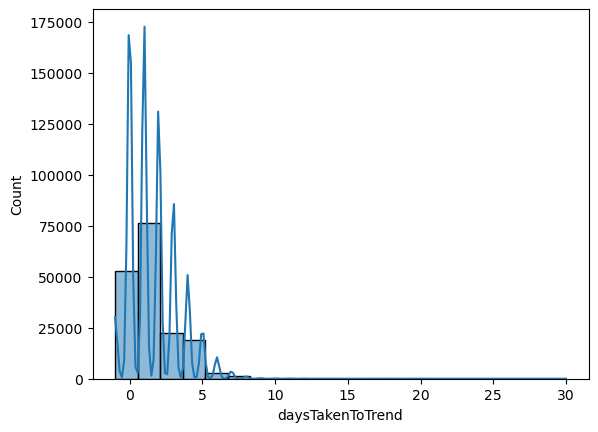

In [18]:
sns.histplot(data['daysTakenToTrend'], kde = True, bins = 20)

From the above plot, 

## EDA